In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 데이터 불러오기

In [37]:
DATA_PATH = '../input/plant-pathology-2020-fgvc7/'
train = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')
submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

train.shape, test.shape, submission.shape

((1821, 5), (1821, 1), (1821, 5))

In [38]:
# 라벨링한 데이터
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [39]:
# 아이디
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [40]:
# 각각의 타겟을 확률로 예측하라
submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


## 데이터 시각화

In [41]:

healthy = train.loc[ train.healthy ==1]
healthy.head()

,image_id,healthy,multiple_diseases,rust,scab
2,Train_2,1,0,0,0
4,Train_4,1,0,0,0
5,Train_5,1,0,0,0
9,Train_9,1,0,0,0
13,Train_13,1,0,0,0


In [42]:
multiple_disease = train.loc[train['multiple_diseases']==1]
rust = train.loc[train['rust']==1]
scab = train.loc[train['scab']==1]

In [43]:
healthy.shape, multiple_disease.shape, rust.shape, scab.shape

((516, 5), (91, 5), (622, 5), (592, 5))

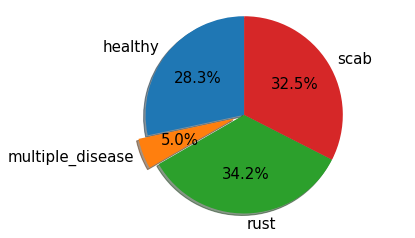

In [44]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('font', size = 15)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'healthy', 'multiple_disease', 'rust', 'scab'
sizes = [516, 91, 622, 592]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

- 이미지 출력

In [52]:
import matplotlib.gridspec as gridspect # 서브플롯 배치
import cv2 # OpenCV 라이브러리

# 이미지 출력 함수
def show_image(img_ids, rows=2, cols=3):
    
    assert len(img_ids) <= rows * cols # 이미지가 행/열 갯수보다 많으면 오류 발생
    
    plt.figure(figsize=(15,8)) # 전체 figure 크기 설정
    
    grid = gridspect.GridSpec(rows, cols) # 서브플롯 배치
    
    # 이미지 출력
    for idx, img_id in enumerate(img_ids):
        img_path = f'{DATA_PATH}/images/{img_id}.jpg' # 이미지 파일 경로 접근
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(grid[idx])
        ax.imshow(image) # 이미지 출력


- 각 타깃값별 image_id 6개

In [46]:
num_of_imgs = 6
last_healthy_img_ids = healthy['image_id'][-num_of_imgs:]
last_multiple_disease_img_ids = multiple_disease['image_id'][-num_of_imgs:]
last_rust_img_ids = rust['image_id'][-num_of_imgs:]
last_scab_img_ids = scab['image_id'][-num_of_imgs:]

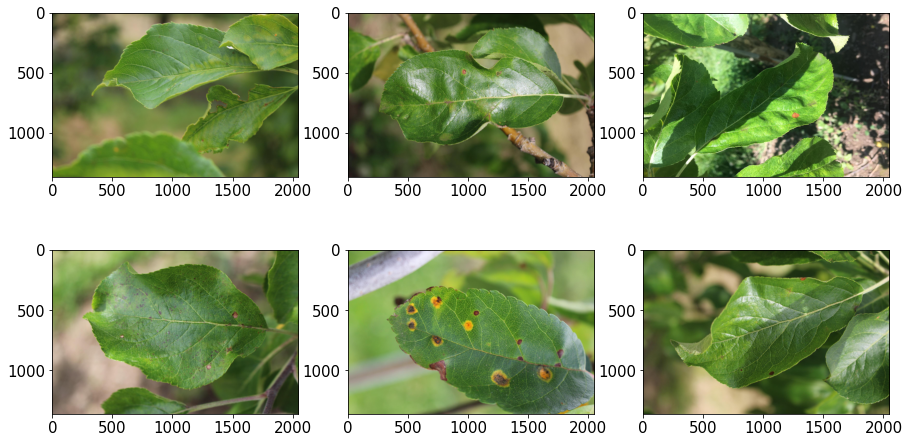

In [60]:
show_image(last_multiple_disease_img_ids)

## 파이토치로 모델 만들어보기
- 시드값 및 gpu설정

In [57]:
import torch
import random
import os

# 시드 값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # CPU
torch.cuda.manual_seed_all(seed) # 다중 GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False


- GPU 장비 설정

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 데이터셋 분리
- 데이터가 편향적이니깐, 층화추출로 데이터를 분리해야 한다.

In [62]:
from sklearn.model_selection import train_test_split 
train, valid = train_test_split(train, 
                                test_size = 0.1,
                                stratify = train[['healthy', 'multiple_diseases', 'rust', 'scab']],# 층화추출
                                random_state=42)

train.shape, valid.shape

((1638, 5), (183, 5))

## 데이터셋 클래스 정의

In [64]:
from torch.utils.data import Dataset # 데이터생성을 위한 클래스

class ImageDataset(Dataset):
    
    # 초기화 메서드
    def __init__(self, df, img_dir='./', transform = None, is_test=False):
        super().__init__() # 상속받은 Dataset의 __init__() 메서드 호출
        
        # 전달받은 인수들 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
        
    # 데이터셋 크기 반환 메서드
    def __len__(self):
        return len(self.df)
    
    # 각 인덱스(idx)에 해당하는 데이터 반환 메서드
    def __getitem__(self, idx):
        img_id   = self.df.iloc[idx,0]                  # 이미지 ID
        img_path = self.img_dir + img_id + '.jpg'       # 이미지 파일 경로
        image    = cv.imread(img_path)                  # 이미지 파일 읽기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 이미지 색상 보정
        
        # 이미지 변환
        if self.transform is not None:
            # 정의된 데이터 변환 생성 함수 적용
            image = self.transform(image=image)['image']
            
        # 테스트 데이터면 이미지 데이터만 반환
        # 훈련데이터면, 이미지 데이터와 타깃값의 라벨도 같이 반환
        if self.is_test:
            return image # 테스트일때
        else:
            # 이미지 + 타깃값 반환
            # 가장 큰 타깃값이 healthy ->0, multi -> 1 , rust ->2, scab ->3
            label = np.argmax(self.df.iloc[idx, 1:5])
            return image, label # 훈련 / 검증


# 이미지 변환기 정의
- albumentations : Pytorch에서 주로 사용하는 데이터 증강용 이미지 변환기 라이브러리
    + 참조 : https://github.com/albumentations-team/albumentations

In [69]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 훈련 데이터용 변환기
transform_train = A.Compose([
    A.Resize(450,650),                                      # 이미지 크기 조절
    A.RandomBrightnessContrast(brightness_limit = 0.2,      # 밝기 조절 
                               contrast_limit = 0.2, p=0.3),
    A.VerticalFlip(p=0.2),                                  # 상하 대칭 변환
    A.HorizontalFlip(p=0.5),                                # 좌우 대칭 변환
    A.ShiftScaleRotate(shift_limit = 0.1 , 
                       scale_limit = 0.2,
                       rotate_limit = 30,
                       p = 0.3),
    A.OneOf([A.Emboss(p=1),                                 # 양각화, Sharpen, 블러링 효과
             A.Sharpen(p=1), 
             A.Blur(p=1)], p=0.3),
    A.PiecewiseAffine(p=0.3),                               # 이미지 모양 전체를 변화시킴
    A.Normalize(),                                          # 정규화 변환
    ToTensorV2()                                            # 텐서로 변환
    
])

- 테스트 변환기

In [70]:
transfrom_test = A.Compose([
    A.Resize(450, 650),
    A.Normalize(),
    ToTensorV2()
])